# Notes on the Methods and Formulas

### Parameters
Parameters can be set in `configs.parameters.json`, for example:
```json
{
    "mc_horizon": 100,
    "mc_paths": 10000,
    "var_accounts": 1000,
    "var_percentile": 0.1,
    "accounts_min_borrow_eth": 0.2,
    "accounts_max_health": 2.0
}
```

#### The Graph (Compound-v2)
Used for current information on Compound. Total borrows, total supply, exchange rate, collateral factor and so on. 
Api at `src.the_graph_api.TheGraphAPI`. 

#### Coingecko (Historical Prices)
Use file: `data/coingecko_prices.csv`

Created by download script `download_historical_prices.py`. The script has a runtime of ~1h, because it sends about 600 requests to coingecko. The free API allows 10-50 requests per minute, so I use a sleep of 6 seconds to never send more than 10 requests per minute. 
Api at `src.coingecko_api.CoingeckoAPI`. 

Time window: `2022-11-21` to `2022-11-20`

Should be updated if gets too old compared to the timestamp of data from The Graph. 

### Volatility and Simulation of Trajectories
Calculated from the historical prices timeseries. Standard deviation of the log-returns. The log is used, because for the Monte Carlo method we model the price path by a Brownian Motion / Weiner Process, where the log-returns follow a Normal Distribution with $\mu=0$ and $\sigma=vol$. 

Implementation: `src.measures.calc_volatility`, `src.measures.monte_carlo_simulation`

### Maximum Insolvency for an Account

To estimate the maximum Insolvency, we use the 10 simulated szenarios of assets prices. 

`borrowValue` for each asset is calculated using the field `borrow_balance_underlying` of the account. 

`collateralValue` is the sum of `supply_balance_underlying` multiplied by their `collatoralFactor`s. 

Then the Insolvency is `insolvency = borrowValue - collateralValue`. We do this 10 times (for the 10 simulated szenarios), and take the Maximum Insolvency Value. 

### Estimate VaR by Total Estimated Debt

Above we saw how to estimate the maximum debt of one account.

Now, we want to estimate the Value at Risk of Compound. We do the following:
- For `mc_paths` (N) simulations of the asset prices.
- Calculate the potential debt of all `var_accounts`. 
- Sum the debt if the account turns unhealthy (collateral < borrow), call `total_debt`
- Now have N total debts. Find the `var_percentile` value as the `VaR` value 

> There is a 10% chance Compound will have a loss of 443899 USD or more, due to under-collateralized accounts. The simulation is based of a time horizon of 100 days. And a sample of 1000 accounts.

When requesting account info, I limited to accounts with `min_borrow_value_in_eth = 0.2` and `max_health = 1.5` so they likely have some impact on the debt calculation (can be changed in `parameters.json`). The real loss will be bigger, because also seemingly more save accounts now could get into a dangerous state, also the small accounts with small borrow_value would add up. 

### Runtime
The use of numpy and matrix multiplication keep the runtime low. On my machine (Intel MacBook Pro), the Monte Carlo Simulation of 10.000 * 17 paths for 100 days horizon only took 10 sec. 
Also the `calc_collateral/borrow_value_usd` functions use matrix multiplication and return instantly (output 10.000 * 17).

Requesting the account information from the `CompoundAPI` can take a while. In the current setup with `var_accounts=1000` it took me 60 seconds. The `get_accounts()` request limits the request to max 200 accounts each page, and sleeps for a few seconds between requests. 

What takes time is to download the historical prices, this is why the download code is excluded and here we load the prices from a csv.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json

PRICES_FILE = Path.cwd().joinpath("data", "coingecko_prices.csv")
PARAMS_FILE = Path.cwd().joinpath("configs", "parameters.json")


In [2]:
# get current Compound Borrows from The Graph
from src.the_graph_api import TheGraphAPI

tg_api = TheGraphAPI()
borrows = tg_api.get_compound_borrows()

col_dtypes = {
    "symbol":str,
    "underlyingSymbol":str,
    "underlyingName":str, 
    "totalBorrows":float,	
    "totalSupply":float,
    "collateralFactor":float,	
    "exchangeRate":float,
    "underlyingPriceUSD":float,	
    "underlyingPrice":float,
    "blockTimestamp":int,
    }
borrows_df = pd.DataFrame(borrows)
borrows_df = borrows_df.apply(lambda c: c.astype(col_dtypes[c.name]))
borrows_df

,symbol,underlyingSymbol,underlyingName,collateralFactor,exchangeRate,totalBorrows,totalSupply,underlyingPriceUSD,underlyingPrice,blockTimestamp
0,cUSDP,USDP,Pax Dollar,0.000,0.020195,1.973789e+04,1.473193e+06,1.000000,0.000862,1669192775
1,cTUSD,TUSD,TrueUSD,0.000,0.020554,5.487941e+06,3.924373e+08,1.000000,0.000858,1669211087
2,cREP,REP,Reputation,0.000,0.020041,5.590882e+01,5.470486e+04,6.961100,0.004323,1667094731
3,cUNI,UNI,Uniswap,0.750,0.020300,4.302904e+05,2.186814e+08,5.388733,0.004648,1669229315
4,cUSDC,USDC,USD//C,0.855,0.022680,2.519425e+08,2.964080e+10,1.000000,0.000856,1669231847
5,cSUSHI,SUSHI,SushiToken,0.700,0.020471,6.630333e+05,1.403798e+08,1.173512,0.001012,1669229291
6,cETH,ETH,Ether,0.825,0.020076,1.385459e+04,1.823402e+07,1167.430000,1.000000,1669231691
7,cDAI,DAI,Dai Stablecoin,0.835,0.022106,1.821761e+08,1.843752e+10,1.000357,0.000863,1669229279
8,cBAT,BAT,Basic Attention Token,0.650,0.020676,4.446289e+05,7.200996e+09,0.226898,0.000195,1669210835
9,cCOMP,COMP,Compound,0.650,0.020414,1.125105e+04,3.064799e+07,38.013822,0.032788,1669229267


Have two entries for `DAI` and `wBTC` each... only keep the bigger one for now
```
{
  "underlyingSymbol": "DAI",
  "underlyingName": "Dai Stablecoin",
  "borrowRate": "0.0233026004452608",
  "totalBorrows": "211524161.923877439677332104",
  "collateralFactor": "0.835",
  "underlyingPriceUSD": "1.000773",
  "blockTimestamp": 1669045535,
  "accrualBlockNumber": 16019369
},
{
  "underlyingSymbol": "DAI",
  "underlyingName": "Dai Stablecoin v1.0 (DAI)",
  "borrowRate": "0.0501467542606656",
  "totalBorrows": "240.64852988575940222",
  "collateralFactor": "0",
  "underlyingPriceUSD": "6.210826",
  "blockTimestamp": 1668979619,
  "accrualBlockNumber": 16013904
},
....
{
  "underlyingSymbol": "WBTC",
  "underlyingName": "Wrapped BTC",
  "borrowRate": "0.0206864728473312",
  "totalBorrows": "0.39387562",
  "collateralFactor": "0.7",
  "underlyingPriceUSD": "15929.996902",
  "blockTimestamp": 1669001867,
  "accrualBlockNumber": 16015751
},
{
  "underlyingSymbol": "WBTC",
  "underlyingName": "Wrapped BTC",
  "borrowRate": "0.0221761103560704",
  "totalBorrows": "152.21575285",
  "collateralFactor": "0.7",
  "underlyingPriceUSD": "16182.771321",
  "blockTimestamp": 1669043411,
  "accrualBlockNumber": 16019192
},
```

In [3]:
borrows_df = borrows_df.sort_values(by=["underlyingSymbol", "totalBorrows"], ascending=False).reset_index(drop=True)
borrows_df = borrows_df.drop_duplicates(subset=["underlyingSymbol"])
borrows_df = borrows_df.sort_values(by=["underlyingSymbol"]).reset_index(drop=True)
borrows_df

,symbol,underlyingSymbol,underlyingName,collateralFactor,exchangeRate,totalBorrows,totalSupply,underlyingPriceUSD,underlyingPrice,blockTimestamp
0,cAAVE,AAVE,Aave Token,0.730,0.020307,7.522294e+03,7.697107e+05,57.549660,0.048670,1669230371
1,cBAT,BAT,Basic Attention Token,0.650,0.020676,4.446289e+05,7.200996e+09,0.226898,0.000195,1669210835
2,cCOMP,COMP,Compound,0.650,0.020414,1.125105e+04,3.064799e+07,38.013822,0.032788,1669229267
3,cDAI,DAI,Dai Stablecoin,0.835,0.022106,1.821761e+08,1.843752e+10,1.000357,0.000863,1669229279
4,cETH,ETH,Ether,0.825,0.020076,1.385459e+04,1.823402e+07,1167.430000,1.000000,1669231691
5,cFEI,FEI,Fei USD,0.000,0.020136,2.496479e+03,8.882565e+04,0.997575,0.000624,1667774747
6,cLINK,LINK,ChainLink Token,0.790,0.020171,2.485256e+04,3.453729e+07,6.410000,0.005560,1669227311
7,cREP,REP,Reputation,0.000,0.020041,5.590882e+01,5.470486e+04,6.961100,0.004323,1667094731
8,cSUSHI,SUSHI,SushiToken,0.700,0.020471,6.630333e+05,1.403798e+08,1.173512,0.001012,1669229291
9,cTUSD,TUSD,TrueUSD,0.000,0.020554,5.487941e+06,3.924373e+08,1.000000,0.000858,1669211087


### Monte Carlo Simulation
- Calculate Volatilties
- Simulate Price Paths

In [4]:
from src.measures import calc_volatility, monte_carlo_simulation

with open(PARAMS_FILE) as f:
    params = json.load(f)
    
# load historical prices from coingecko (used scrip `download_historica_prices.ipynb` to prepare data)
prices = pd.read_csv(PRICES_FILE)
symbols = sorted(prices["symbol"].unique())

# calculate volatilities
vols = {}
for symbol in symbols:
    p = prices[prices["symbol"] == symbol]["price"].values
    vols[symbol] = calc_volatility(p)

print(vols)

{'aave': 0.07464626572283103, 'bat': 0.06004059637910412, 'comp': 0.06638834095565146, 'dai': 0.002007655992637203, 'eth': 0.06422278659986509, 'fei': 0.02851061647386272, 'link': 0.07018952104224735, 'rep': 0.07171938656321616, 'sushi': 0.09514300836715131, 'tusd': 0.00282056858179138, 'uni': 0.0697395479254225, 'usdc': 0.0021574718617547875, 'usdp': 0.0043466418878502005, 'usdt': 0.0019460020558690057, 'wbtc': 0.04429704461003883, 'yfi': 0.06864343781384731, 'zrx': 0.0728031524419769}


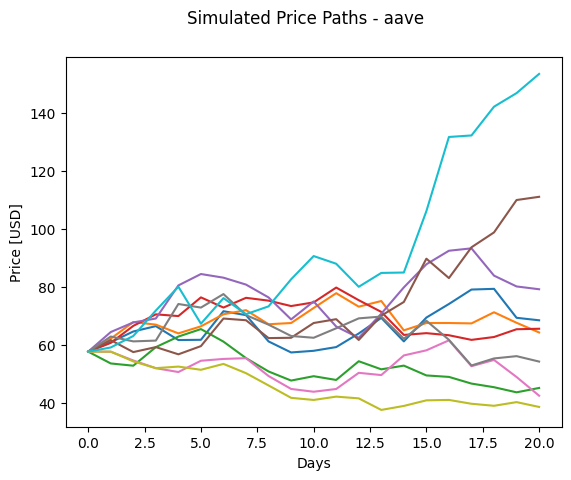

In [5]:
# plot example of Monte Carlo Paths (aave)
from src.measures import simulate_path
from src.plots import plot_mc_paths
from matplotlib import pyplot as plt

symbol = "aave"
price = borrows_df[borrows_df["underlyingSymbol"] == symbol.upper()]["underlyingPriceUSD"].iloc[0]
paths = [simulate_path(price, vols[symbol], horizon=20) for _ in range(10)]

fig = plot_mc_paths(symbol, paths)
plt.show()

In [6]:
# Simulate Monte Carlo Paths for all Symbols
mc_paths = {}
for symbol in symbols:
    price = borrows_df[borrows_df["underlyingSymbol"] == symbol.upper()]["underlyingPriceUSD"].iloc[0]
    mc_paths[symbol] = monte_carlo_simulation(price, vols[symbol], params["mc_horizon"], params["mc_paths"])

mc_prices = pd.DataFrame(mc_paths).T
mc_prices_small = mc_prices[mc_prices.columns.tolist()[:10]]

print(f"For each asset simulated {params['mc_paths']} paths with time horizon of {params['mc_horizon']} days.")
print(f"Showing 10 example states:")
mc_prices_small

For each asset simulated 10000 paths with time horizon of 100 days.
Showing 10 example states:


,0,1,2,3,4,5,6,7,8,9
aave,14.606176,159.959933,39.203513,73.306259,76.138398,86.989156,130.198710,22.189951,21.476472,25.244592
bat,0.303486,0.889222,0.143689,0.495335,0.131599,0.989329,0.755421,0.319977,0.146330,0.254778
comp,41.290838,73.088609,23.875483,25.732414,40.749789,52.095604,25.971633,50.080690,25.801511,31.649949
dai,0.965703,1.014648,0.983895,1.010720,1.032586,0.991396,1.034774,0.988744,0.962522,1.020231
eth,1155.651945,2548.432567,1921.949794,4690.291282,538.506579,601.295273,642.947221,895.818325,1061.080759,747.445319
fei,0.747160,0.728432,0.853307,0.964088,1.462973,1.085448,0.698576,0.958214,1.857749,1.388545
link,4.549298,8.735646,3.268811,3.154240,4.928740,7.856215,9.748066,5.060794,6.555218,8.249484
rep,3.517037,3.135125,4.960139,3.469676,3.298028,10.494779,3.556116,3.850358,8.602798,31.862753
sushi,0.737596,0.724812,0.847260,0.826890,1.944695,2.607279,3.273208,0.745515,0.218646,0.458101
tusd,1.011589,0.978390,0.990472,0.999436,0.985303,0.985942,1.076504,1.000336,0.989094,1.018522


# Calculate Value of Borrows and Collateral

- value of cTokens in USD: `amount_cToken * exchange_rate * price_usd`
- calculate `collateralValue` and `borrowValue` 

The `health` on Compound is `collateralValue / borrowValue`. A value of < 1 means, that the account is under-collateralized and subject to liquidation. The `health` value from the Compound API is calculated with the collateral and borrow values in ETH (`total_collateral_value_in_eth / total_borrow_value_in_eth.`). Since my simulation is based on the historic asset prices in USD, I will also calculate the health based on collateral and borrow value in USD. 

## Maximum Insolvency for an Account

To estimate the maximum Insolvency, we use the 10 simulated szenarios of assets prices. 

`borrowValue` for each asset is calculated using the field `borrow_balance_underlying` of the account. 

`collateralValue` is the sum of `supply_balance_underlying` multiplied by their `collatoralFactor`s. 

Then the Insolvency is `insolvency = borrowValue - collateralValue`. We do this 10 times (for the 10 simulated szenarios), and take the Maximum Insolvency Value. 

In [7]:
# get accounts from compound that are already close to insolvency (max_health = 1.5)

from src.compound_api import CompoundApi
c_api = CompoundApi()
accounts = c_api.get_accounts(amount=4, max_health=1.5, min_borrow_value_in_eth=0.2)

In [8]:
a = accounts[1]
print(a["total_borrow_value_in_eth"], a["total_collateral_value_in_eth"], a["health"])
pd.DataFrame(a["tokens"])

{'value': '1045.069173456962250287336737'} {'value': '1563.991065354033611908921091'} {'value': '1.4965431045875562412982917994339835315547090762062229039604051597623145542961'}


,address,borrow_balance_underlying,lifetime_borrow_interest_accrued,lifetime_supply_interest_accrued,safe_withdraw_amount_underlying,supply_balance_underlying,symbol
0,0x35a18000230da775cac24873d00ff85bccded550,{'value': '0'},{'value': '0'},{'value': '82.11387704802343'},{'value': '0.0'},{'value': '0.0'},cUNI
1,0x70e36f6bf80a52b3b46b3af8e106cc0ed743e8e4,{'value': '0'},{'value': '0'},{'value': '0.7590489164445753'},{'value': '0.0'},{'value': '0.0'},cCOMP
2,0x7713dd9ca933848f6819f38b8352d9a15ea73f67,{'value': '0.0'},{'value': '92.93684214689749'},{'value': '0.0'},{'value': '0.0'},{'value': '0.0'},cFEI
3,0x39aa39c021dfbae8fac545936693ac917d5e7563,{'value': '1220045.1051688613'},{'value': '59619.8284988613'},{'value': '0.0'},{'value': '0.0'},{'value': '0.0'},cUSDC
4,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,{'value': '0'},{'value': '0'},{'value': '1.6731968106562'},{'value': '312.3086042822191260899936531'},{'value': '1895.746745883677'},cETH


In [9]:
# calculate account's health using the usd value

def format_assets_to_df(tokens, field):
    empty_tokens_df = pd.DataFrame(index=symbols)
    tokens = {t["symbol"][1:].lower(): float(t[field]["value"]) for t in tokens}
    df = pd.Series(tokens)

    empty_tokens_df["amount"] = df
    empty_tokens_df.fillna(0, inplace=True)
    return empty_tokens_df["amount"].values

account_tokens = pd.DataFrame(index=symbols)
account_tokens["borrow"] = format_assets_to_df(a["tokens"], "borrow_balance_underlying")
account_tokens["supply"]  = format_assets_to_df(a["tokens"], "supply_balance_underlying")
account_tokens

,borrow,supply
aave,0.000000e+00,0.000000
bat,0.000000e+00,0.000000
comp,0.000000e+00,0.000000
dai,0.000000e+00,0.000000
eth,0.000000e+00,1895.746746
fei,0.000000e+00,0.000000
link,0.000000e+00,0.000000
rep,0.000000e+00,0.000000
sushi,0.000000e+00,0.000000
tusd,0.000000e+00,0.000000


In [10]:
from src.measures import calc_borrow_value_usd, calc_collateral_value_usd

b = calc_borrow_value_usd(
    n_ctoken=account_tokens["borrow"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    prices=borrows_df["underlyingPriceUSD"].values
)

c = calc_collateral_value_usd(
    n_ctoken=account_tokens["supply"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    collateral_factor=borrows_df["collateralFactor"].values,
    prices=borrows_df["underlyingPriceUSD"].values
)
print(f"calculated health of account (usd price): {c.sum()/b.sum()}, api health (eth price) {a['health']['value'][:5]}.")

calculated health of account (usd price): 1.3247174553822212, api health (eth price) 1.496.


### How would the Monte Carlo simulated prices affect the supply and borrow vlaues?

In [11]:
mc_borrow_values = calc_borrow_value_usd(
    n_ctoken=account_tokens["borrow"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    prices=mc_prices_small.values
)
mc_collateral_values = calc_collateral_value_usd(
    n_ctoken=account_tokens["supply"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    collateral_factor=borrows_df["collateralFactor"].values,
    prices = mc_prices_small.values
)

# calculate simulated debts
debt = mc_borrow_values.sum(axis=0) - mc_collateral_values.sum(axis=0)
max_debt = debt.max()
print(f"Max debt of account {a['address']} from {len(mc_prices_small.columns)} simulated szenarios: {max_debt} USD")

Max debt of account 0xf6aaada76ea7f044ffa028565b028740dce5389f from 10 simulated szenarios: 10125.602587693651 USD


### Estimate VaR by Total Estimated Debt

Above we saw how to estimate the maximum debt of one account.

Now, we want to estimate the Value at Risk of Compound. We do the following:
- For `mc_paths` (N) simulations of the asset prices
- Calculate the potential debt of all `var_accounts`. 
- Sum the debt if the account turns unhealthy (collateral < borrow), call `total_debt`
- Now have N total debts. Find the `var_percentile` value as the `VaR` value 

>There is a 10% chance that Compound will have a loss of `VaR`, due to insolvent accounts. 

Limit to accounts with `min_borrow_value_in_eth = 0.2` so they have some impact (can be changed in `parameters.json`)


In [12]:
# if `var_accounts` is big, this could run a while (1000 accounts took for me 1 minute.)

accounts = c_api.get_accounts(
    amount=params["var_accounts"], 
    min_borrow_value_in_eth=params["accounts_min_borrow_eth"], 
    max_health=params["accounts_max_health"]
    )

In [13]:
total_debt = np.zeros(params["mc_paths"])
always_healthy_accounts = 0
for a in accounts:
    mc_borrow_values = calc_borrow_value_usd(
        n_ctoken=format_assets_to_df(a["tokens"], "borrow_balance_underlying"), 
        exchange_rate=borrows_df["exchangeRate"].values, 
        prices=mc_prices.values
    )
    mc_collateral_values = calc_collateral_value_usd(
        n_ctoken=format_assets_to_df(a["tokens"], "supply_balance_underlying"), 
        exchange_rate=borrows_df["exchangeRate"].values, 
        collateral_factor=borrows_df["collateralFactor"].values,
        prices = mc_prices.values
    )

    # calculate simulated debts
    debt = mc_borrow_values.sum(axis=0) - mc_collateral_values.sum(axis=0)
    # only keep positive debts ("account is unhealthy")
    debt = np.maximum(np.zeros(params["mc_paths"]), debt)

    total_debt += debt
    if debt.sum()==0:
        always_healthy_accounts += 1

print(f"Of {params['var_accounts']}, {always_healthy_accounts} always stayed healthy, " \
    f"in all {params['mc_paths']} simulations. " \
    "If too many accounts stay health, change parameters `accounts_min_borrow_eth` or `accounts_max_health` for the `get_accounts` request.")


Of 1000, 184 always stayed healthy, in all 10000 simulations. If too many accounts stay health, change parameters `accounts_min_borrow_eth` or `accounts_max_health` for the `get_accounts` request.


There is a 10% chance Compound will have a loss of 443858 USD or more, due to under-collateralized accounts. The simulation is based of a time horizon of 100 days. And a sample of 1000 accounts.


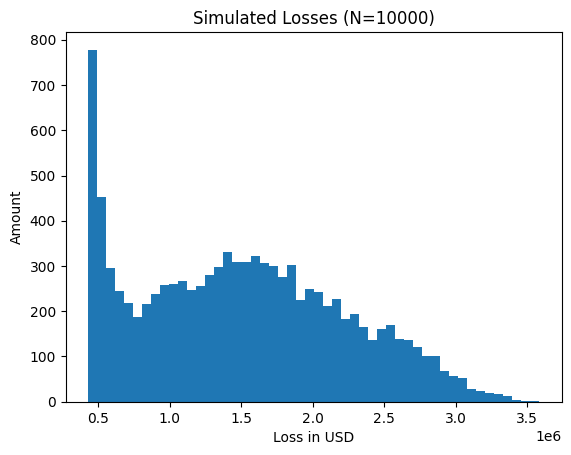

In [14]:
from src.plots import plot_loss_histogram

fig = plot_loss_histogram(total_debt, params["mc_paths"])

var_critical_debt = np.percentile(total_debt, 1-params["var_percentile"])
print(f"There is a {int(params['var_percentile']*100)}% chance Compound will have a loss of {var_critical_debt:.0f} USD or more, due to under-collateralized accounts. "\
    f"The simulation is based of a time horizon of {params['mc_horizon']} days. And a sample of {params['var_accounts']} accounts.")